# Loan Default Prediction
Given a dataset of loan defaults with features, the aim is to predict if a person will default on a loan.

## Approach

- Clean and transform data 
- Exploratory data analysis
- Feature engineering
  - unsupervised learning model for clustering
  - calculated ratios
- Model Design
  - supervised learning models for classification
- Feature Evaluation
  - review feature contribution and relationships
- Next Steps

## Setup

In [1]:
# load required packages
import logging
import warnings

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import register_matplotlib_converters
from shapash.explainer.smart_explainer import SmartExplainer
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook
from xgboost import XGBClassifier


In [2]:
# quality-of-life
pd.options.mode.use_inf_as_na = True
# pd.options.plotting.backend = "plotly"
pd.set_option("display.max_columns", 150)
plt.style.use("ggplot")
warnings.filterwarnings("ignore")

# logging
logging.basicConfig(
    filename="crystalball.log",
    filemode="a",
    format="%(asctime)s %(message)s",
    datefmt="%Y-%m-%d %H:%M",
    level=logging.INFO,
)
logger = logging.getLogger()
# logger.setLevel(logging.INFO)
# handler = logging.StreamHandler()
# handler.setLevel(logging.INFO)
# logformat = logging.Formatter("%(message)s")
# handler.setFormatter(logformat)
# logger.addHandler(handler)


## Extract

In [3]:
# training data
d_train = pd.read_csv("train.csv", index_col="Id")
d_train.sample(5).head()


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
Id,,,,,,,,,,,,,,,,,
6412,Own Home,3799240.0,< 1 year,0.0,16.0,16.0,242176.0,0.0,19.0,0.0,debt consolidation,Short Term,307934.0,106039.0,27228.0,735.0,0
6924,Rent,719682.0,9 years,0.0,8.0,12.6,234872.0,0.0,56.0,0.0,debt consolidation,Short Term,188584.0,83372.0,14754.0,705.0,0
3780,Home Mortgage,801724.0,10+ years,0.0,13.0,34.5,0.0,0.0,36.0,0.0,home improvements,Long Term,237468.0,0.0,17845.0,744.0,0
2425,Own Home,1299410.0,10+ years,0.0,7.0,28.6,1146464.0,0.0,NaN,0.0,debt consolidation,Short Term,161216.0,107920.0,10612.0,750.0,0
5827,Rent,863094.0,2 years,0.0,12.0,19.0,617298.0,0.0,NaN,0.0,debt consolidation,Long Term,434544.0,274018.0,12932.0,734.0,0


In [4]:
# testing data
d_test = pd.read_csv("test.csv", index_col="Id")
d_test.sample(5).head()


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
Id,,,,,,,,,,,,,,,,
8447,Home Mortgage,1519449.0,10+ years,0.0,16.0,22.4,822668.0,0.0,67.0,0.0,debt consolidation,Long Term,543026.0,260737.0,25831.0,727.0
8725,Rent,1350482.0,2 years,0.0,8.0,15.8,130922.0,0.0,7.0,0.0,debt consolidation,Short Term,154704.0,26011.0,10433.0,721.0
9222,Home Mortgage,4471080.0,1 year,0.0,15.0,27.4,1247290.0,0.0,NaN,0.0,other,Short Term,284746.0,1010420.0,71165.0,724.0
9215,Home Mortgage,1628889.0,2 years,0.0,19.0,15.1,795432.0,0.0,9.0,0.0,debt consolidation,Short Term,199694.0,212268.0,20904.0,733.0
7705,Rent,NaN,3 years,0.0,6.0,7.2,278696.0,0.0,NaN,0.0,debt consolidation,Short Term,363616.0,127566.0,20074.0,NaN


## Clean and transform data

In [5]:
# set up default column for test data
d_test["Credit Default"] = 0

# set labels for training and test data
d_train["Label"] = "train"
d_test["Label"] = "test"

# merge training and test data
datasets = [d_train, d_test]
df = pd.concat(datasets)

# review data
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                10000 non-null  object 
 1   Annual Income                 7930 non-null   float64
 2   Years in current job          9543 non-null   object 
 3   Tax Liens                     10000 non-null  float64
 4   Number of Open Accounts       10000 non-null  float64
 5   Years of Credit History       10000 non-null  float64
 6   Maximum Open Credit           10000 non-null  float64
 7   Number of Credit Problems     10000 non-null  float64
 8   Months since last delinquent  4561 non-null   float64
 9   Bankruptcies                  9983 non-null   float64
 10  Purpose                       10000 non-null  object 
 11  Term                          10000 non-null  object 
 12  Current Loan Amount           10000 non-null  float64
 13  Cu

In [6]:
# factorise categorical data
cols = df.select_dtypes(include="object").columns
indx = pd.DataFrame(columns=["Feature", "Factor", "Value"])
for col in cols:
    df[col] = pd.factorize(df[col])[0]

# review factors
df.sample(10).head(10)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Label
Id,,,,,,,,,,,,,,,,,,
2631,1,3245504.0,0,0.0,13.0,24.0,1169102.0,0.0,NaN,0.0,0,1,436590.0,751203.0,55714.0,708.0,0,0
7957,1,1294679.0,-1,0.0,8.0,17.0,558536.0,0.0,41.0,0.0,0,0,107910.0,265791.0,9893.0,730.0,0,1
5420,2,1511488.0,3,0.0,6.0,17.8,487696.0,0.0,NaN,0.0,0,1,507540.0,412775.0,30230.0,702.0,0,0
9623,1,1529614.0,1,0.0,12.0,15.8,540298.0,0.0,NaN,0.0,0,0,349844.0,295830.0,25494.0,739.0,0,1
7185,0,2955602.0,8,0.0,8.0,13.8,132418.0,0.0,33.0,0.0,10,0,110396.0,33611.0,19901.0,743.0,0,0
513,1,2242342.0,9,0.0,11.0,21.8,253022.0,0.0,24.0,0.0,2,1,442618.0,145958.0,17434.0,673.0,0,0
9256,0,508326.0,-1,0.0,4.0,9.0,110616.0,0.0,NaN,0.0,2,0,130790.0,6498.0,940.0,727.0,0,1
5035,2,1527448.0,0,0.0,11.0,31.8,256476.0,1.0,NaN,1.0,0,0,123794.0,53827.0,16802.0,712.0,0,0
2311,1,1019008.0,8,0.0,12.0,18.0,724218.0,0.0,39.0,0.0,0,0,252120.0,415302.0,28957.0,720.0,0,0


<AxesSubplot:>

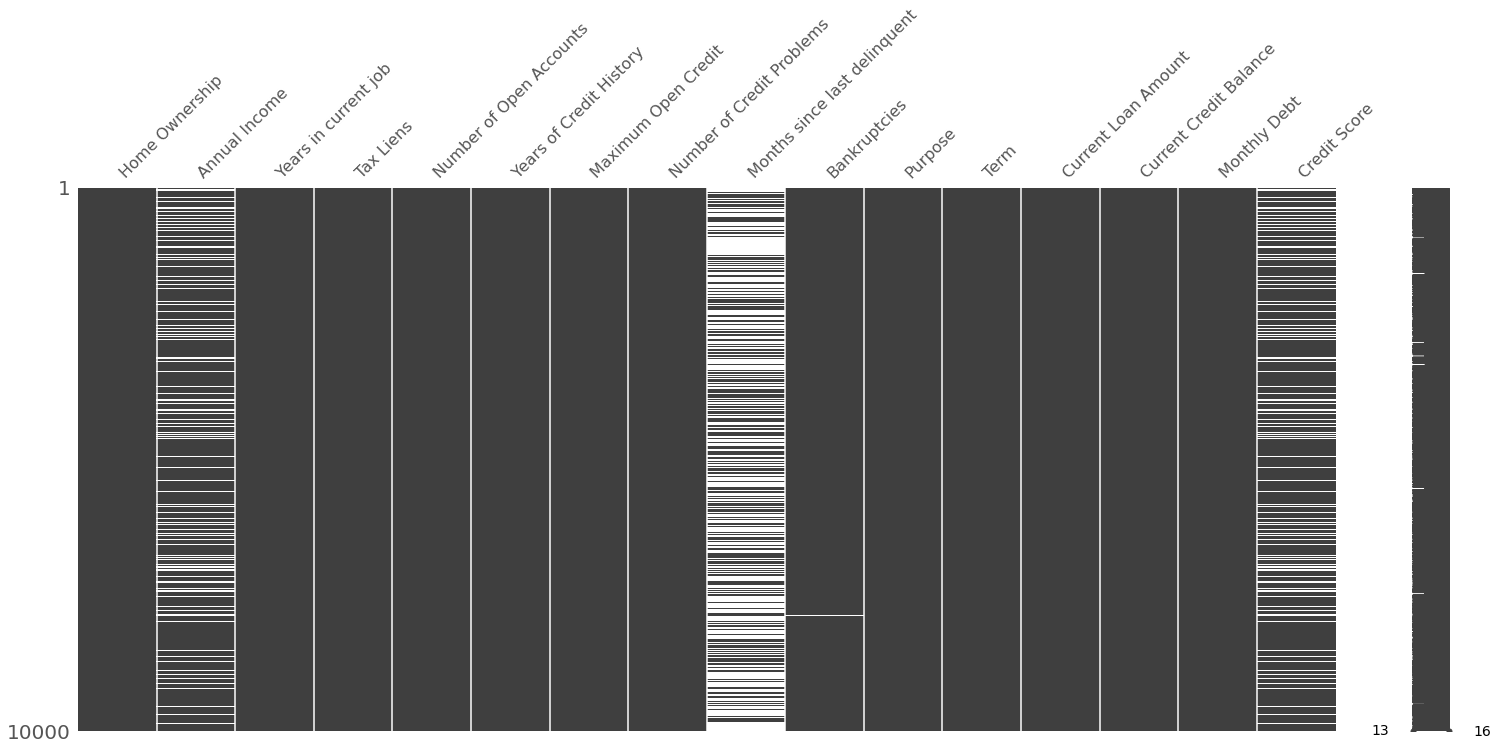

In [7]:
# visualise missing data
msno.matrix(df.iloc[:, :-2])


<AxesSubplot:>

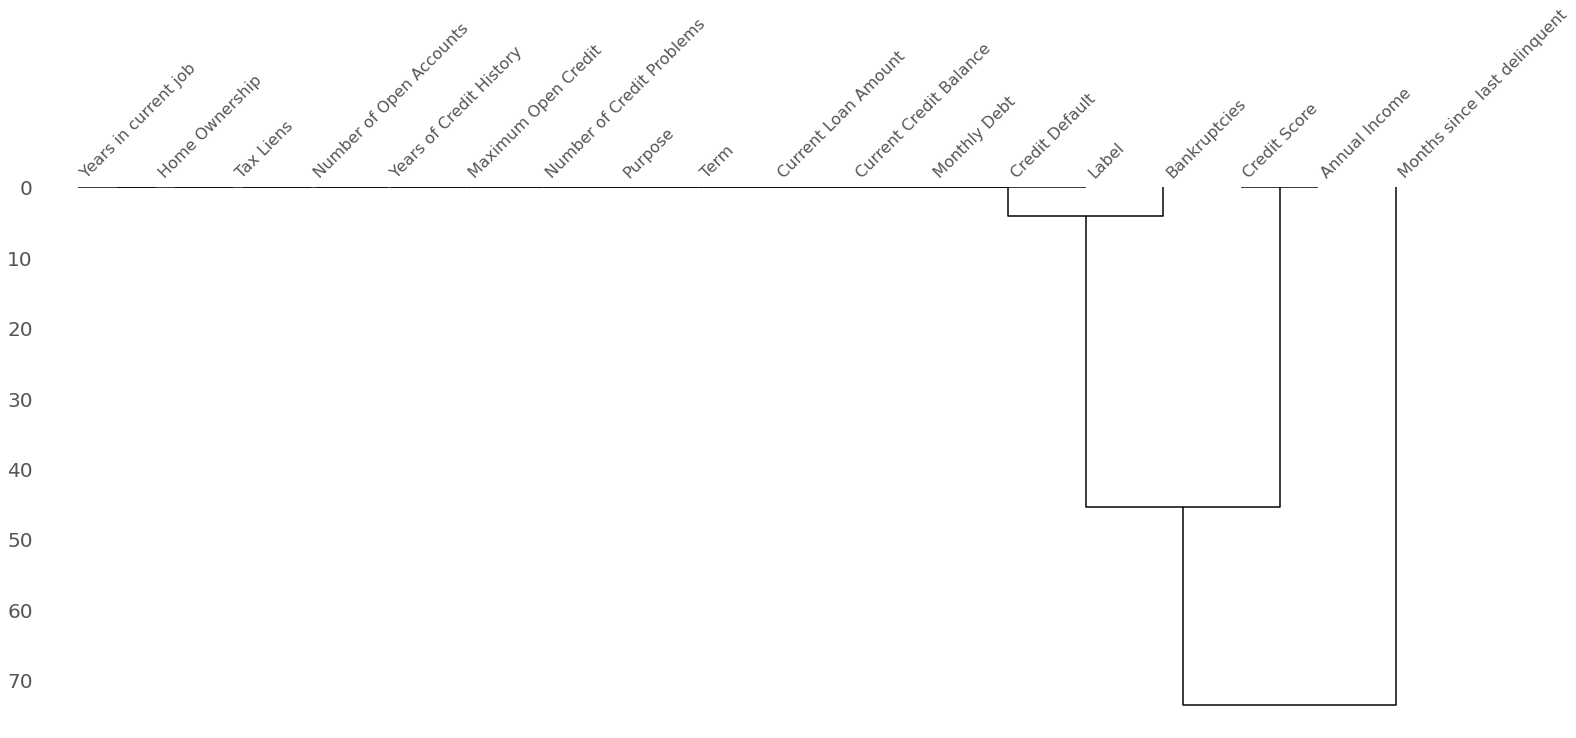

In [8]:
# visualise correlation between missing data
msno.dendrogram(df)


In [9]:
# replace NaN's where appropriate
cols = ["Months since last delinquent", "Credit Default", "Bankruptcies"]
for col in cols:
    df[col] = df[col].fillna(0)


In [10]:
# predict missing data
# annual income
# training set
X_train = df.loc[~df["Annual Income"].isna()].drop(
    ["Annual Income", "Credit Score", "Credit Default", "Label"], axis=1
)
y_train_income = df.loc[~df["Annual Income"].isna(), ["Annual Income"]]

# prediction set
X_pred_income = df.loc[df["Annual Income"].isna()].drop(
    ["Annual Income", "Credit Score", "Credit Default", "Label"], axis=1
)

# build simple non-parametric model
reg = RandomForestRegressor(n_estimators=250, random_state=77)
model_income = reg.fit(X_train, y_train_income)

logger.info(f" * ---------- Model Metrics ---------- *")
logger.info(f"Predict missing data: Annual Income")
logger.info(f"Accuracy: {model_income.score(X_train, y_train_income):.2%}")
logger.info(f" * ---------- * --------- * ---------- *")

# replace missing values with predictions
null_income = df.loc[df["Annual Income"].isna(), "Annual Income"].index
pred_income = model_income.predict(X_pred_income)
for i, j in enumerate(null_income):
    df.at[j, "Annual Income"] = pred_income[i]


INFO:root: * ---------- Model Metrics ---------- *
INFO:root:Predict missing data: Annual Income
INFO:root:Accuracy: 91.57%
INFO:root: * ---------- * --------- * ---------- *


In [11]:
# predict missing data
# credit score
# training set
X_train = df.loc[~df["Credit Score"].isna()].drop(
    ["Annual Income", "Credit Score", "Credit Default", "Label"], axis=1
)
y_train_credit = df.loc[~df["Credit Score"].isna(), ["Credit Score"]]

# prediction set
X_pred_credit = df.loc[df["Credit Score"].isna()].drop(
    ["Annual Income", "Credit Score", "Credit Default", "Label"], axis=1
)

# build simple non-parametric model
model_credit = reg.fit(X_train, y_train_credit)

logger.info(f" * ---------- Model Metrics ---------- *")
logger.info(f"Predict missing data: Credit Score")
logger.info(f"Accuracy: {model_credit.score(X_train, y_train_credit):.2%}")
logger.info(f" * ---------- * --------- * ---------- *")

# replace missing values with predictions
null_credit = df.loc[df["Credit Score"].isna(), "Credit Score"].index
pred_credit = model_credit.predict(X_pred_credit)
for i, j in enumerate(null_credit):
    df.at[j, "Credit Score"] = pred_credit[i]


INFO:root: * ---------- Model Metrics ---------- *
INFO:root:Predict missing data: Credit Score
INFO:root:Accuracy: 85.85%
INFO:root: * ---------- * --------- * ---------- *


In [12]:
# scale data
scaler = MinMaxScaler()
df.iloc[:, :-1] = pd.DataFrame(scaler.fit_transform(df.iloc[:, :-1]))


## Exploratory data analysis

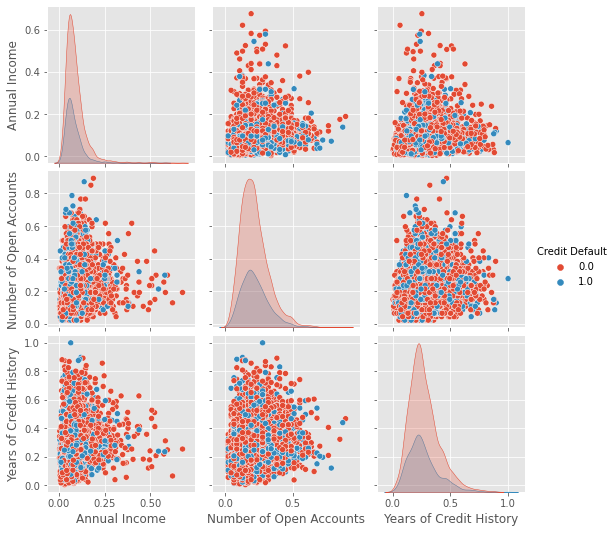

In [13]:
# visualise distribution and correlation between features
sns.pairplot(
    df.loc[df["Label"] == 0][
        [
            "Annual Income",
            "Number of Open Accounts",
            "Years of Credit History",
            "Credit Default",
        ]
    ],
    hue="Credit Default",
)
plt.show()


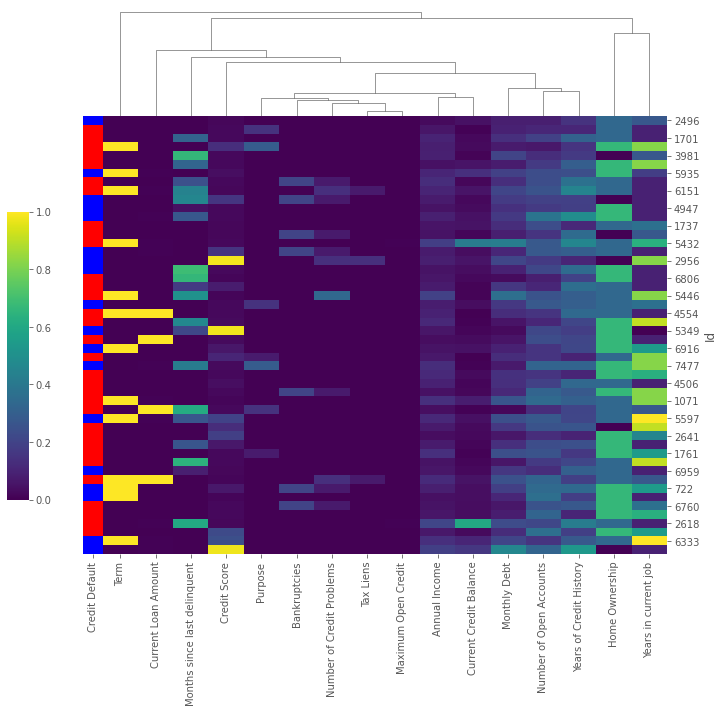

In [14]:
# visualise correlations
ds = df.loc[df["Label"] == 0].sample(50)
row_labels = dict(zip(ds["Credit Default"].unique(), "br"))
row_colors = ds["Credit Default"].map(row_labels)
g = sns.clustermap(
    ds.drop(["Label", "Credit Default"], axis=1),
    row_cluster=False,
    row_colors=row_colors,
    dendrogram_ratio=(0.1, 0.2),
    cbar_pos=(0, 0.3, 0.03, 0.4),
    cmap="viridis",
)
plt.show()


## Feature engineering

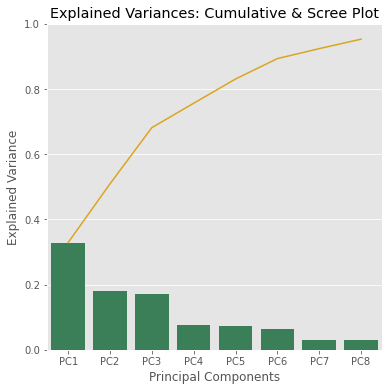

    PC       Var    CumVar
0  PC1  0.328960  0.328960
1  PC2  0.180156  0.509116
2  PC3  0.172572  0.681688
3  PC4  0.074793  0.756481
4  PC5  0.074353  0.830834
5  PC6  0.062618  0.893452
6  PC7  0.030654  0.924106
7  PC8  0.028993  0.953099


In [15]:
# principal components analysis
# feature set excluding outcome and label
X = df.drop(["Credit Default", "Label"], axis=1)

# calculate pca parameters
n = 8
pca = PCA(n_components=n)
pca.fit(X)

# explained variances
pv = pd.DataFrame(columns=["PC", "Var", "CumVar"])
cv = 0
for i in range(0, n):
    cv += pca.explained_variance_ratio_[i]
    pv.loc[len(pv)] = f"PC{i+1}", pca.explained_variance_ratio_[i], cv

# cumulative
fig, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(x="PC", y="CumVar", data=pv, color="goldenrod")

# scree plot
sns.barplot(x="PC", y="Var", data=pv, color="seagreen")

ax.set_title("Explained Variances: Cumulative & Scree Plot")
ax.set_xlabel("Principal Components")
ax.set_ylabel("Explained Variance")
plt.show()

print(pv)


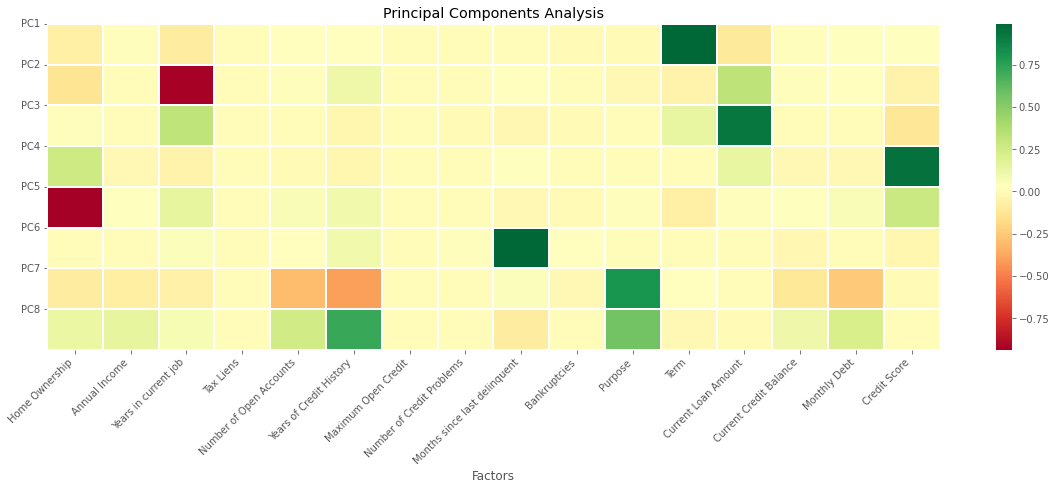

In [16]:
# extract pca components
ht = pd.DataFrame(columns=X.columns.values)
for i in range(0, n):
    ht.loc[len(ht)] = pca.components_[i]
    
# visualise component weights
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(ht, linewidths=0.05, cmap="RdYlGn")
plt.xticks(rotation=45, ha="right")
plt.yticks(range(n), pv["PC"].values, rotation=0)
ax.set_title("Principal Components Analysis")
ax.set_xlabel("Factors")
plt.show()


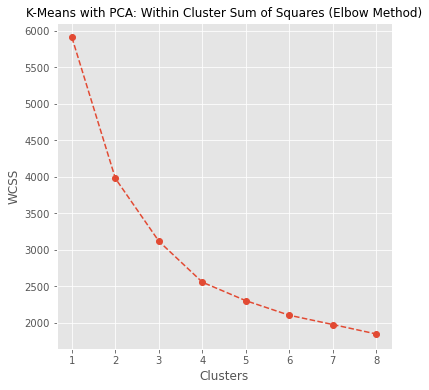

In [17]:
# find optimal number of clusters
wcss = pd.DataFrame(columns=["clusters", "wcss"])
for i in range(0, n):
    pca = KMeans(n_clusters=i + 1)
    pca.fit(X)
    wcss.loc[len(wcss)] = i + 1, pca.inertia_

fig = plt.figure(figsize=(6, 6))
plt.plot(wcss["clusters"], wcss["wcss"], marker="o", linestyle="--")
plt.title("K-Means with PCA: Within Cluster Sum of Squares (Elbow Method)", fontsize=12)
plt.xlabel("Clusters")
plt.ylabel("WCSS")
plt.show()


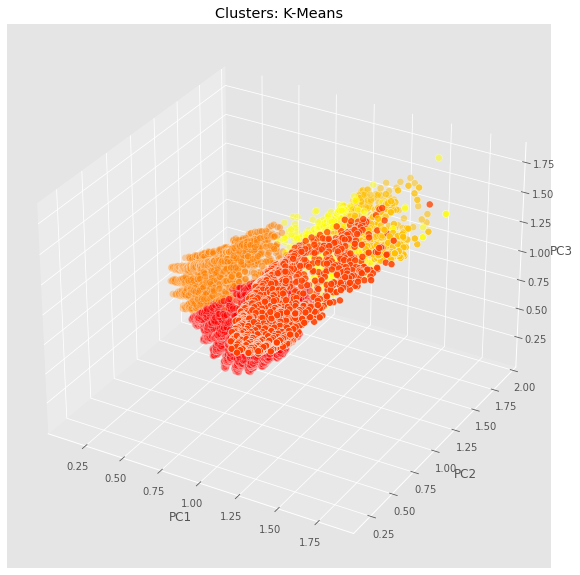

In [18]:
# fit kmeans model to top components
kmeans = KMeans(n_clusters=5)
pfeature = pca.fit_transform(X)
km_clusters = kmeans.fit_predict(pfeature)

# visualise clusters with top components
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection="3d")
ax.scatter3D(
    pfeature[:, 0],
    pfeature[:, 1],
    pfeature[:, 2],
    c=km_clusters,
    cmap="autumn",
    edgecolor="white",
    s=50,
)
ax.set_title("Clusters: K-Means")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


In [19]:
# add clusters
features = pd.DataFrame(km_clusters, columns=["Cluster"])


In [20]:
# income per open accounts
features["Income Per Account"] = X["Annual Income"] / X["Number of Open Accounts"]


In [21]:
# credit per year of history
features["Credit Per Year"] = X["Maximum Open Credit"] / X["Years of Credit History"]


In [22]:
# merge new features into original dataset
df = (
    X.merge(features, left_index=True, right_index=True)
    .merge(df["Credit Default"], left_index=True, right_index=True)
    .merge(df["Label"], left_index=True, right_index=True)
)


## Model Design & Evaluation

In [23]:
# split data back into training and test sets
train = df.loc[df["Label"] == 0].drop("Label", axis=1)
test = df.loc[df["Label"] == 1].drop("Label", axis=1)

# check rows
print(f"Variance: {df.shape[0] - (train.shape[0] + test.shape[0])} rows")


Variance: 0 rows


### Random Forest Classifier

In [24]:
# set target variable and features
X = train.drop("Credit Default", axis=1)
y = train["Credit Default"]

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# model
clf = RandomForestClassifier()
forest = clf.fit(X_train, y_train)
y_pred = forest.predict(X_test)

# print results
logger.info(f"---------- Metrics ----------")
logger.info(f"| Accuracy:  {metrics.accuracy_score(y_test, y_pred):06.2%}         |")
logger.info(f"| ROC AUC:   {metrics.roc_auc_score(y_test, y_pred):06.2%}         |")
logger.info(f"| F1 score:  {metrics.f1_score(y_test, y_pred):06.2%}         |")
logger.info(f"| Precision: {metrics.precision_score(y_test, y_pred):06.2%}         |")
logger.info(f"| Recall:    {metrics.recall_score(y_test, y_pred):06.2%}         |")
logger.info(f"-----------------------------")


INFO:root:---------- Metrics ----------
INFO:root:| Accuracy:  78.40%         |
INFO:root:| ROC AUC:   63.16%         |
INFO:root:| F1 score:  42.96%         |
INFO:root:| Precision: 72.62%         |
INFO:root:| Recall:    30.50%         |
INFO:root:-----------------------------


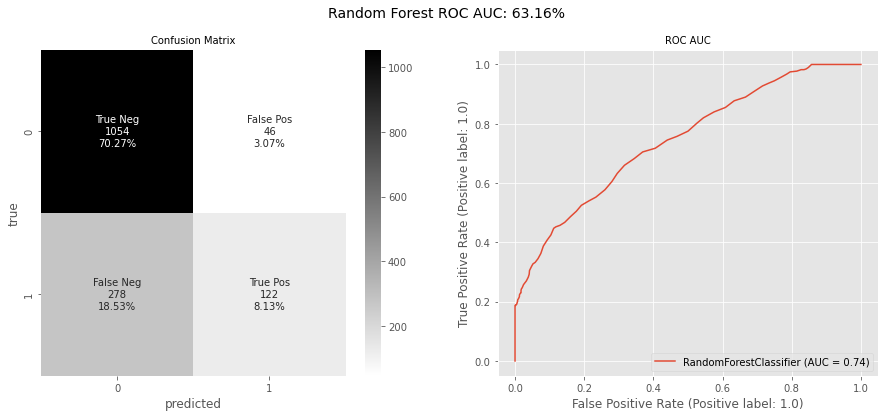

In [25]:
# set up plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# confusion matrix
cfs = metrics.confusion_matrix(y_test, y_pred)
names = ["True Neg", "False Pos", "False Neg", "True Pos"]
count = [f"{count:0.0f}" for count in cfs.flatten()]
perct = [f"{perct:0.2%}" for perct in cfs.flatten()/np.sum(cfs)]
label = [f"{a}\n{b}\n{c}" for a, b, c in zip(names, count, perct)]
label = np.asarray(label).reshape(2, 2)

sns.heatmap(cfs, annot=label, fmt="", cmap="binary", ax=ax[0])
ax[0].set_xlabel("predicted")
ax[0].set_ylabel("true")
ax[0].set_title(f"Confusion Matrix", fontsize=10)

# ROC AUC graph
metrics.plot_roc_curve(clf, X_test, y_test, ax=ax[1])
ax[1].set_title(f"ROC AUC", fontsize=10)
fig.suptitle(f"Random Forest ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.2%}", fontsize=14)
plt.show()

### XGBoost Classifier

In [26]:
# set target variable and features
X = train.drop("Credit Default", axis=1)
y = train["Credit Default"]

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# model
clf = XGBClassifier()
shroom = clf.fit(X_train, y_train)
y_pred = shroom.predict(X_test)

# print results
logger.info(f"---------- Metrics ----------")
logger.info(f"| Accuracy:  {metrics.accuracy_score(y_test, y_pred):06.2%}         |")
logger.info(f"| ROC AUC:   {metrics.roc_auc_score(y_test, y_pred):06.2%}         |")
logger.info(f"| F1 score:  {metrics.f1_score(y_test, y_pred):06.2%}         |")
logger.info(f"| Precision: {metrics.precision_score(y_test, y_pred):06.2%}         |")
logger.info(f"| Recall:    {metrics.recall_score(y_test, y_pred):06.2%}         |")
logger.info(f"-----------------------------")


[23:35:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:root:---------- Metrics ----------
INFO:root:| Accuracy:  75.53%         |
INFO:root:| ROC AUC:   64.03%         |
INFO:root:| F1 score:  46.42%         |
INFO:root:| Precision: 66.25%         |
INFO:root:| Recall:    35.73%         |
INFO:root:-----------------------------


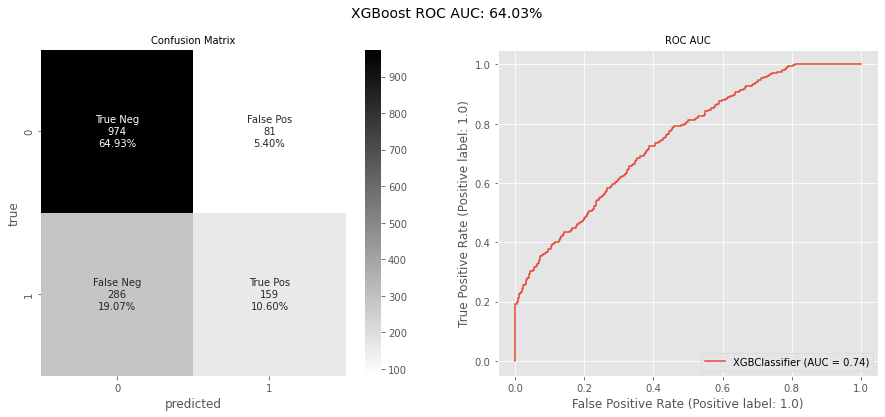

In [27]:
# set up plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# confusion matrix
cfs = metrics.confusion_matrix(y_test, y_pred)
names = ["True Neg", "False Pos", "False Neg", "True Pos"]
count = [f"{count:0.0f}" for count in cfs.flatten()]
perct = [f"{perct:0.2%}" for perct in cfs.flatten()/np.sum(cfs)]
label = [f"{a}\n{b}\n{c}" for a, b, c in zip(names, count, perct)]
label = np.asarray(label).reshape(2, 2)

sns.heatmap(cfs, annot=label, fmt="", cmap="binary", ax=ax[0])
ax[0].set_xlabel("predicted")
ax[0].set_ylabel("true")
ax[0].set_title(f"Confusion Matrix", fontsize=10)

# ROC AUC graph
metrics.plot_roc_curve(clf, X_test, y_test, ax=ax[1])
ax[1].set_title(f"ROC AUC", fontsize=10)
fig.suptitle(f"XGBoost ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.2%}", fontsize=14)
plt.show()


### LightGBM Classifier

In [28]:
# set target variable and features
X = train.drop("Credit Default", axis=1)
y = train["Credit Default"]

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# model
clf = LGBMClassifier()
tundra = clf.fit(X_train, y_train)
y_pred = tundra.predict(X_test)

# print results
logger.info(f"---------- Metrics ----------")
logger.info(f"| Accuracy:  {metrics.accuracy_score(y_test, y_pred):06.2%}         |")
logger.info(f"| ROC AUC:   {metrics.roc_auc_score(y_test, y_pred):06.2%}         |")
logger.info(f"| F1 score:  {metrics.f1_score(y_test, y_pred):06.2%}         |")
logger.info(f"| Precision: {metrics.precision_score(y_test, y_pred):06.2%}         |")
logger.info(f"| Recall:    {metrics.recall_score(y_test, y_pred):06.2%}         |")
logger.info(f"-----------------------------")

INFO:root:---------- Metrics ----------
INFO:root:| Accuracy:  78.20%         |
INFO:root:| ROC AUC:   64.69%         |
INFO:root:| F1 score:  46.66%         |
INFO:root:| Precision: 70.44%         |
INFO:root:| Recall:    34.88%         |
INFO:root:-----------------------------


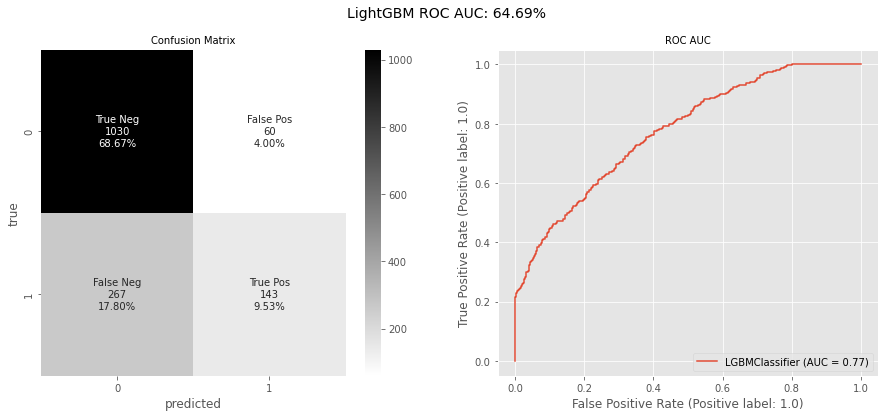

In [29]:
# set up plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# confusion matrix
cfs = metrics.confusion_matrix(y_test, y_pred)
names = ["True Neg", "False Pos", "False Neg", "True Pos"]
count = [f"{count:0.0f}" for count in cfs.flatten()]
perct = [f"{perct:0.2%}" for perct in cfs.flatten()/np.sum(cfs)]
label = [f"{a}\n{b}\n{c}" for a, b, c in zip(names, count, perct)]
label = np.asarray(label).reshape(2, 2)

sns.heatmap(cfs, annot=label, fmt="", cmap="binary", ax=ax[0])
ax[0].set_xlabel("predicted")
ax[0].set_ylabel("true")
ax[0].set_title(f"Confusion Matrix", fontsize=10)

# ROC AUC graph
metrics.plot_roc_curve(clf, X_test, y_test, ax=ax[1])
ax[1].set_title(f"ROC AUC", fontsize=10)
fig.suptitle(f"LightGBM ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.2%}", fontsize=14)
plt.show()

In [30]:
# predictions
X_subm = test.drop("Credit Default", axis=1)
y_subm = shroom.predict(X_subm).astype(int)

# submission
subm = pd.DataFrame(y_subm, index=test.index, columns=["Credit Default"])
subm.to_csv("submission.csv")


## Feature Evaluation
SHAP analysis

In [31]:
# set up tree explainer
xpl = SmartExplainer()
xpl.compile(x=X_test, model=tundra)


Backend: Shap TreeExplainer


In [32]:
# feature importance
# prioritise feature engineering and prune low-contributing features
xpl.plot.features_importance()

In [33]:
# top interactions
# examine assumptions about interactions between each feature
xpl.plot.top_interactions_plot(nb_top_interactions=3)

In [34]:
# feature contribution
# detailed view of individual feature contributions
xpl.plot.contribution_plot("Annual Income")

In [35]:
# local instance
# review individual customers
xpl.plot.local_plot(row_num=500)

## Next Steps
1. Feature Engineering
    - Prune features e.g. bankruptcies
    - Derive additional features
    - Improve modelling missing features (GLM)
2. Model Design
    - Conduct grid search to find optimal parameters
    - Test survival analysis model for loan defaults